# Association Rule Mining Lab
**Course:** MSCS-634  
**Lab Assignment:** Lab 6 - Association Rule Mining with Apriori and FP-Growth  
**Student:** Dheeraj K

## Step 1: Data Preparation

This section loads the Online Retail dataset and performs necessary preprocessing steps.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
import time
import os

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create screenshots directory if it doesn't exist
os.makedirs('screenshots', exist_ok=True)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the Online Retail dataset from UCI repository
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(url)

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Dataset loaded successfully!
Dataset shape: (541909, 8)

First few rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Check for missing values and dataset information
print("Dataset Information:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nBasic statistics:")
print(df.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

Missing values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Basic statistics:
            Quantity                    InvoiceDate      

In [4]:
# Data cleaning steps
# Remove rows with missing Description or InvoiceNo
df_clean = df.dropna(subset=['Description', 'InvoiceNo'])

# Remove cancelled transactions (InvoiceNo starting with 'C')
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative quantities (returns)
df_clean = df_clean[df_clean['Quantity'] > 0]

# Remove rows with negative prices
df_clean = df_clean[df_clean['UnitPrice'] > 0]

# Strip whitespace from descriptions
df_clean['Description'] = df_clean['Description'].str.strip()

# Remove transactions with very generic descriptions
df_clean = df_clean[~df_clean['Description'].str.contains('POSTAGE|POST|BANK CHARGES|DISCOUNT', case=False, na=False)]

print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"Rows removed: {df.shape[0] - df_clean.shape[0]}")
print("\nCleaned data sample:")
df_clean.head()

Original dataset shape: (541909, 8)
Cleaned dataset shape: (527553, 8)
Rows removed: 14356

Cleaned data sample:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Group items by transaction (InvoiceNo)
# Each invoice represents one transaction with multiple items
transactions = df_clean.groupby('InvoiceNo')['Description'].apply(list).values.tolist()

print(f"Total number of transactions: {len(transactions)}")
print(f"Sample transaction: {transactions[0][:5]}")  # Show first 5 items of first transaction

Total number of transactions: 19872
Sample transaction: ['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN', 'CREAM CUPID HEARTS COAT HANGER', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'RED WOOLLY HOTTIE WHITE HEART.']


### Exploratory Data Analysis

Visualizing the dataset characteristics to understand item frequencies and co-occurrence patterns.

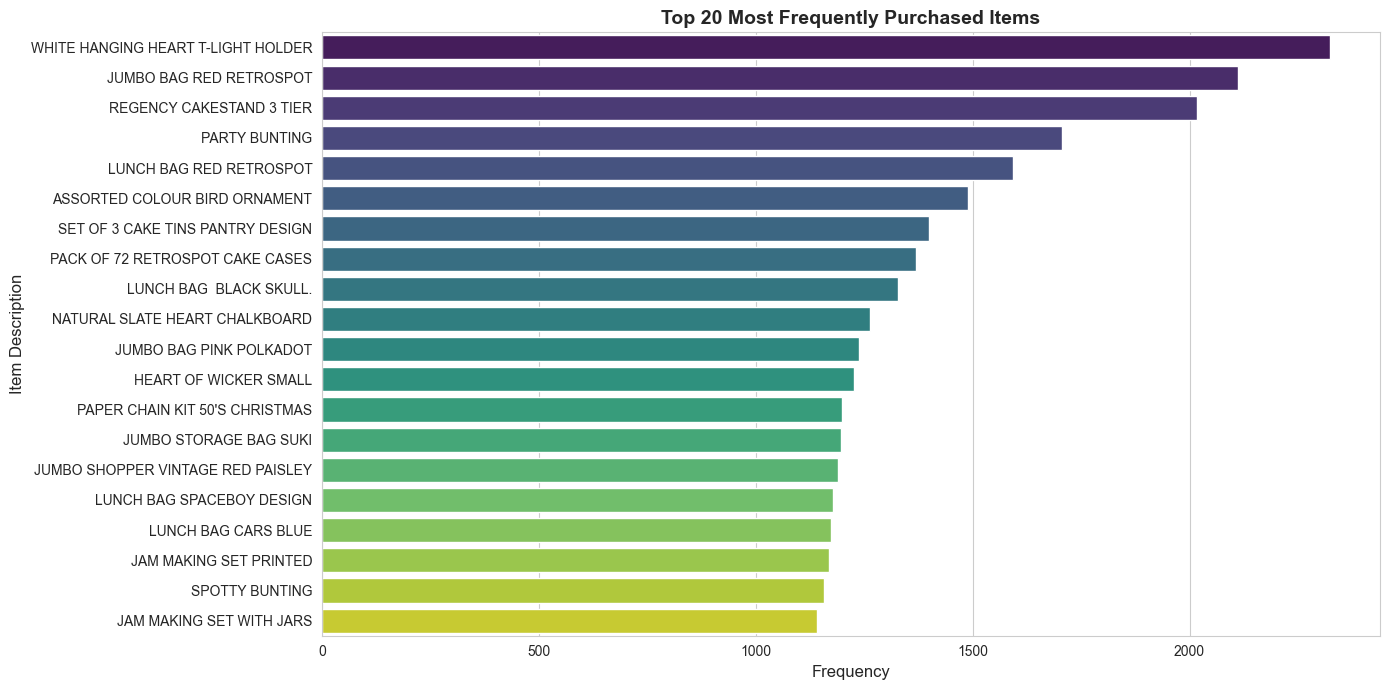

Most popular item: WHITE HANGING HEART T-LIGHT HOLDER with 2323 occurrences


In [6]:
# Visualization 1: Top 20 Most Frequent Items
item_counts = df_clean['Description'].value_counts().head(20)

plt.figure(figsize=(14, 7))
sns.barplot(x=item_counts.values, y=item_counts.index, palette='viridis')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Item Description', fontsize=12)
plt.title('Top 20 Most Frequently Purchased Items', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('screenshots/frequent_items.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Most popular item: {item_counts.index[0]} with {item_counts.values[0]} occurrences")

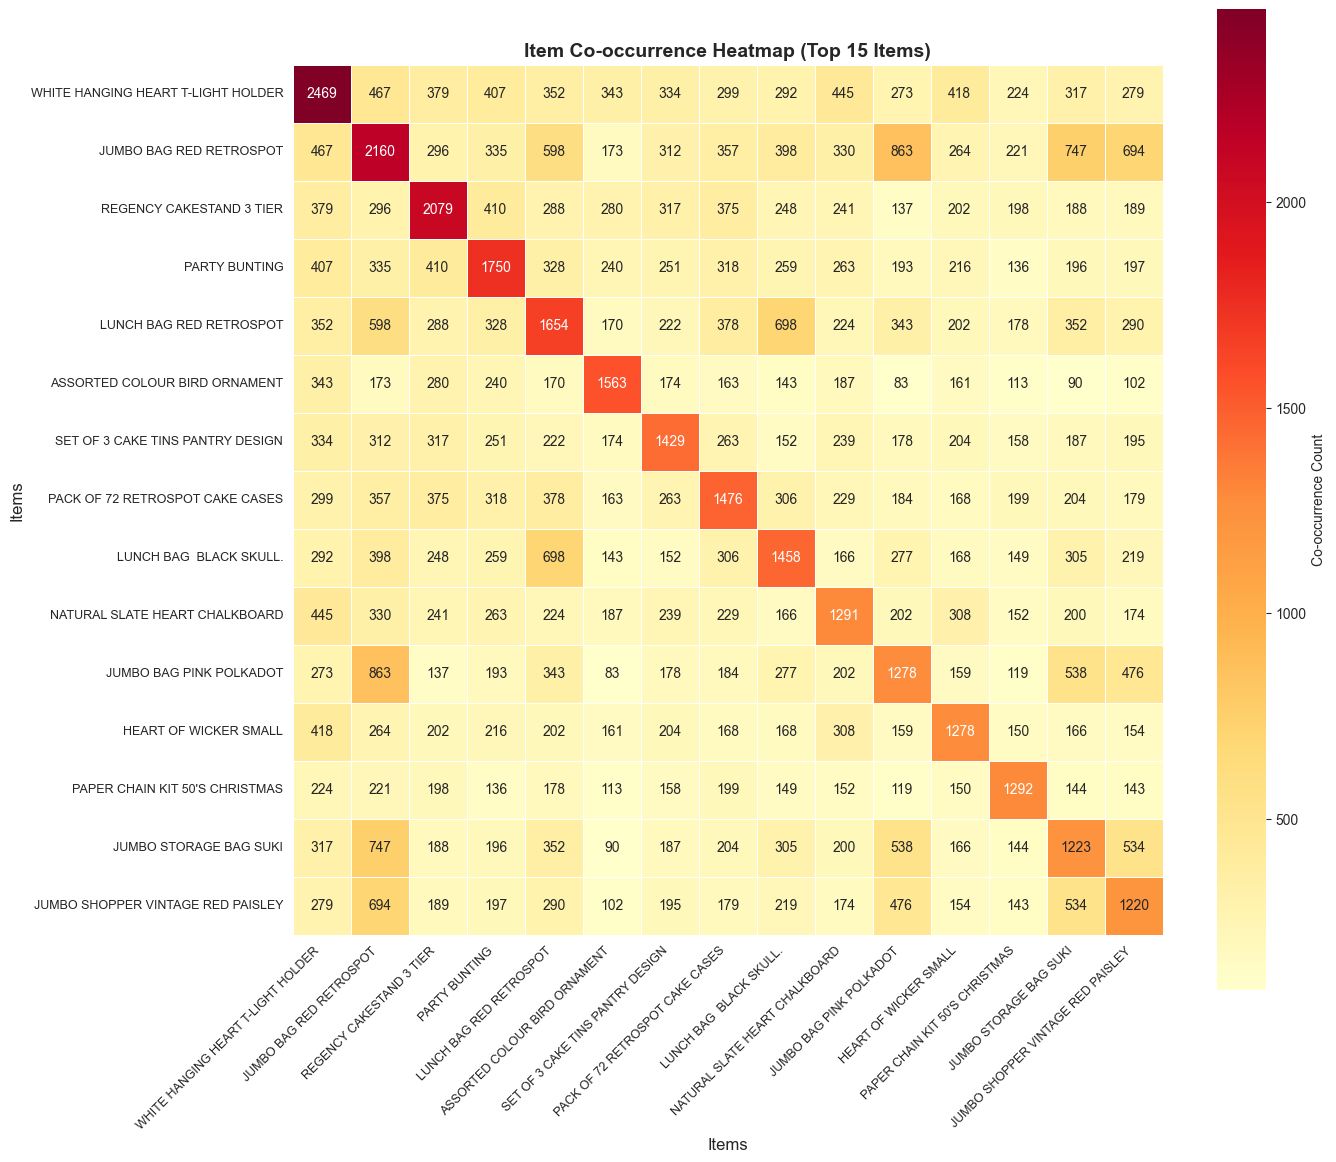

Co-occurrence heatmap shows how often items appear together in transactions


In [7]:
# Visualization 2: Item Co-occurrence Heatmap
# Select top 15 items for better visualization
top_items = df_clean['Description'].value_counts().head(15).index.tolist()

# Create a co-occurrence matrix
cooccurrence_matrix = pd.DataFrame(0, index=top_items, columns=top_items)

for transaction in transactions:
    # Get items in this transaction that are in our top items list
    items_in_transaction = [item for item in transaction if item in top_items]
    # Update co-occurrence for each pair
    for i in range(len(items_in_transaction)):
        for j in range(i, len(items_in_transaction)):
            item1, item2 = items_in_transaction[i], items_in_transaction[j]
            cooccurrence_matrix.loc[item1, item2] += 1
            if i != j:
                cooccurrence_matrix.loc[item2, item1] += 1

# Create heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cooccurrence_matrix, annot=True, fmt='g', cmap='YlOrRd', 
            square=True, linewidths=0.5, cbar_kws={'label': 'Co-occurrence Count'})
plt.title('Item Co-occurrence Heatmap (Top 15 Items)', fontsize=14, fontweight='bold')
plt.xlabel('Items', fontsize=12)
plt.ylabel('Items', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig('screenshots/cooccurrence_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Co-occurrence heatmap shows how often items appear together in transactions")

## Step 2: Frequent Itemset Mining Using Apriori

The Apriori algorithm identifies frequent itemsets by iteratively generating candidate itemsets and pruning those that don't meet the minimum support threshold.

In [8]:
# Convert transactions to one-hot encoded format for Apriori
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Encoded transaction matrix shape: {df_encoded.shape}")
print(f"Number of unique items: {len(te.columns_)}")
print("\nSample of encoded data:")
df_encoded.head()

Encoded transaction matrix shape: (19872, 4002)
Number of unique items: 4002

Sample of encoded data:


,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
# Apply Apriori algorithm with minimum support threshold
min_support = 0.02  # 2% support threshold

print("Running Apriori algorithm...")
start_time = time.time()
frequent_itemsets_apriori = apriori(df_encoded, min_support=min_support, use_colnames=True)
apriori_time = time.time() - start_time

print(f"Apriori execution time: {apriori_time:.4f} seconds")
print(f"Number of frequent itemsets found: {len(frequent_itemsets_apriori)}")
print("\nTop 10 frequent itemsets by support:")
frequent_itemsets_apriori.sort_values('support', ascending=False).head(10)

Running Apriori algorithm...
Apriori execution time: 4.0934 seconds
Number of frequent itemsets found: 378

Top 10 frequent itemsets by support:


,support,itemsets
277,0.113527,(WHITE HANGING HEART T-LIGHT HOLDER)
104,0.105123,(JUMBO BAG RED RETROSPOT)
199,0.100040,(REGENCY CAKESTAND 3 TIER)
159,0.084793,(PARTY BUNTING)
129,0.078704,(LUNCH BAG RED RETROSPOT)
15,0.073219,(ASSORTED COLOUR BIRD ORNAMENT)
221,0.069696,(SET OF 3 CAKE TINS PANTRY DESIGN)
151,0.066425,(PACK OF 72 RETROSPOT CAKE CASES)
122,0.064060,(LUNCH BAG BLACK SKULL.)
141,0.062852,(NATURAL SLATE HEART CHALKBOARD)


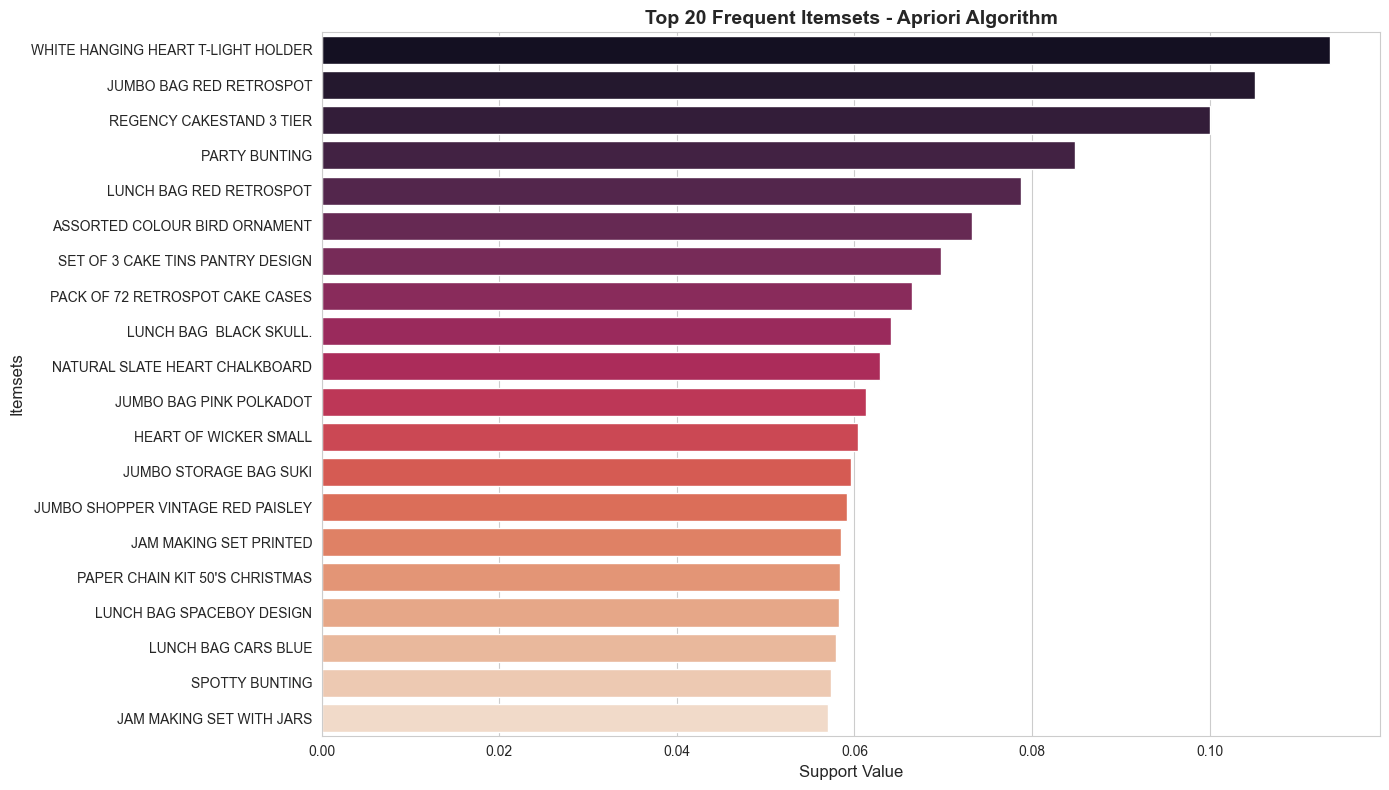

Visualization shows the support values for the most frequent itemsets discovered by Apriori


In [10]:
# Visualization: Top 20 Frequent Itemsets from Apriori
top_itemsets_apriori = frequent_itemsets_apriori.sort_values('support', ascending=False).head(20).copy()

# Convert frozensets to strings for better visualization
top_itemsets_apriori['itemsets_str'] = top_itemsets_apriori['itemsets'].apply(
    lambda x: ', '.join(list(x)[:3]) + ('...' if len(x) > 3 else '')
)

plt.figure(figsize=(14, 8))
sns.barplot(x='support', y='itemsets_str', data=top_itemsets_apriori, palette='rocket')
plt.xlabel('Support Value', fontsize=12)
plt.ylabel('Itemsets', fontsize=12)
plt.title('Top 20 Frequent Itemsets - Apriori Algorithm', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('screenshots/apriori_frequent_itemsets.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization shows the support values for the most frequent itemsets discovered by Apriori")

## Step 3: Frequent Itemset Mining Using FP-Growth

The FP-Growth algorithm uses a compact FP-tree structure to find frequent itemsets without candidate generation, making it more efficient than Apriori for large datasets.

In [11]:
# Apply FP-Growth algorithm with the same minimum support threshold
print("Running FP-Growth algorithm...")
start_time = time.time()
frequent_itemsets_fpgrowth = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)
fpgrowth_time = time.time() - start_time

print(f"FP-Growth execution time: {fpgrowth_time:.4f} seconds")
print(f"Number of frequent itemsets found: {len(frequent_itemsets_fpgrowth)}")
print("\nTop 10 frequent itemsets by support:")
frequent_itemsets_fpgrowth.sort_values('support', ascending=False).head(10)

Running FP-Growth algorithm...
FP-Growth execution time: 3.4139 seconds
Number of frequent itemsets found: 378

Top 10 frequent itemsets by support:


,support,itemsets
0,0.113527,(WHITE HANGING HEART T-LIGHT HOLDER)
66,0.105123,(JUMBO BAG RED RETROSPOT)
164,0.100040,(REGENCY CAKESTAND 3 TIER)
235,0.084793,(PARTY BUNTING)
29,0.078704,(LUNCH BAG RED RETROSPOT)
4,0.073219,(ASSORTED COLOUR BIRD ORNAMENT)
246,0.069696,(SET OF 3 CAKE TINS PANTRY DESIGN)
30,0.066425,(PACK OF 72 RETROSPOT CAKE CASES)
109,0.064060,(LUNCH BAG BLACK SKULL.)
56,0.062852,(NATURAL SLATE HEART CHALKBOARD)


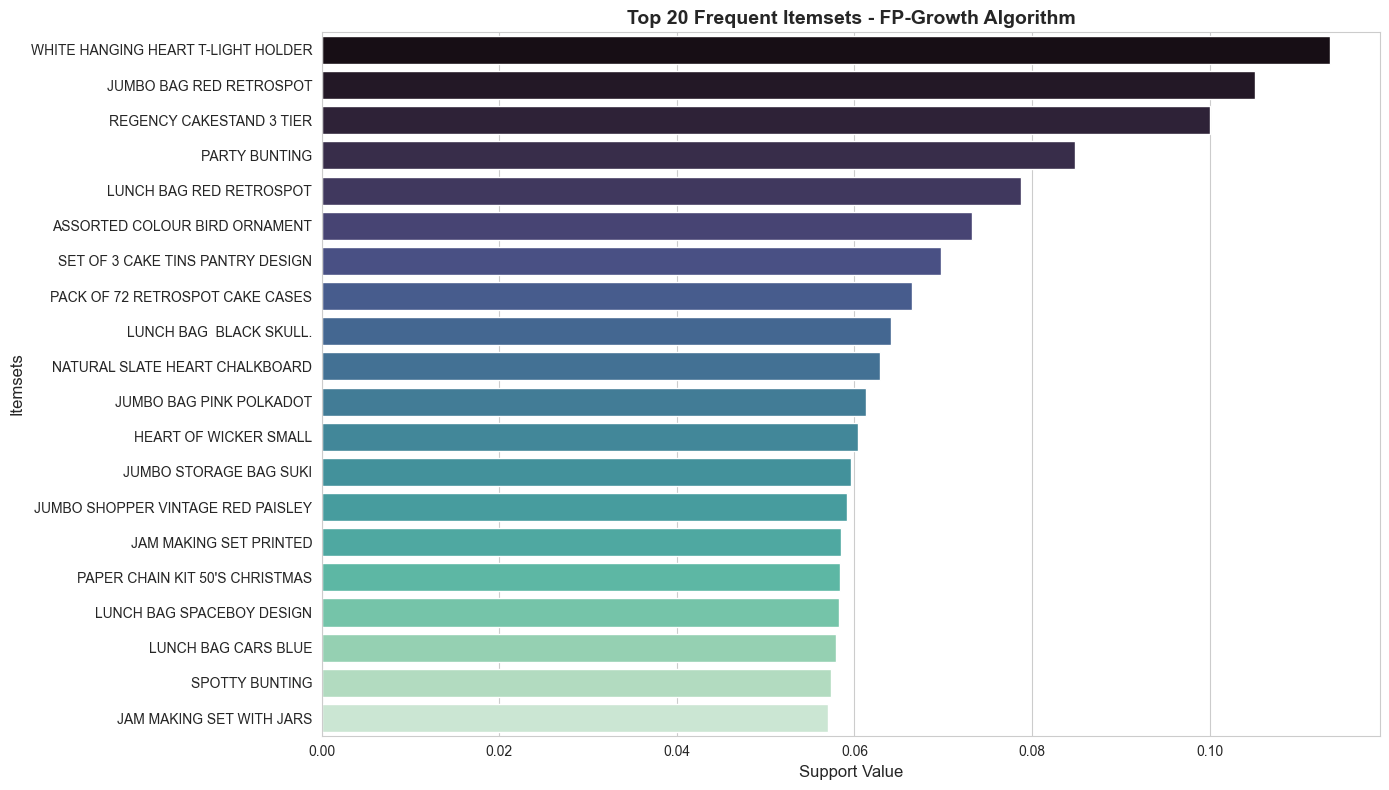

Visualization shows the support values for the most frequent itemsets discovered by FP-Growth


In [12]:
# Visualization: Top 20 Frequent Itemsets from FP-Growth
top_itemsets_fpgrowth = frequent_itemsets_fpgrowth.sort_values('support', ascending=False).head(20).copy()

# Convert frozensets to strings for better visualization
top_itemsets_fpgrowth['itemsets_str'] = top_itemsets_fpgrowth['itemsets'].apply(
    lambda x: ', '.join(list(x)[:3]) + ('...' if len(x) > 3 else '')
)

plt.figure(figsize=(14, 8))
sns.barplot(x='support', y='itemsets_str', data=top_itemsets_fpgrowth, palette='mako')
plt.xlabel('Support Value', fontsize=12)
plt.ylabel('Itemsets', fontsize=12)
plt.title('Top 20 Frequent Itemsets - FP-Growth Algorithm', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('screenshots/fpgrowth_frequent_itemsets.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization shows the support values for the most frequent itemsets discovered by FP-Growth")

<Figure size 1200x600 with 0 Axes>

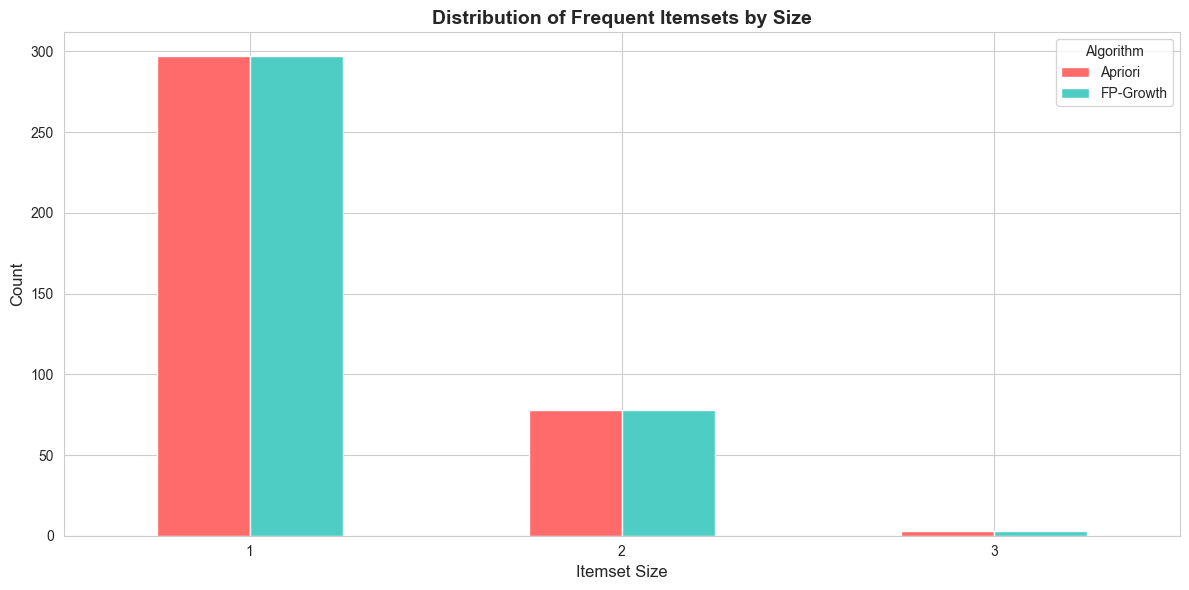

Both algorithms produce the same itemsets when using identical support thresholds


In [13]:
# Compare the number of itemsets by size
apriori_sizes = frequent_itemsets_apriori['itemsets'].apply(len).value_counts().sort_index()
fpgrowth_sizes = frequent_itemsets_fpgrowth['itemsets'].apply(len).value_counts().sort_index()

comparison_df = pd.DataFrame({
    'Apriori': apriori_sizes,
    'FP-Growth': fpgrowth_sizes
}).fillna(0)

plt.figure(figsize=(12, 6))
comparison_df.plot(kind='bar', color=['#FF6B6B', '#4ECDC4'])
plt.xlabel('Itemset Size', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Frequent Itemsets by Size', fontsize=14, fontweight='bold')
plt.legend(title='Algorithm')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('screenshots/itemset_size_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Both algorithms produce the same itemsets when using identical support thresholds")

## Step 4: Generating and Analyzing Association Rules

Association rules are generated from frequent itemsets to identify relationships between items. Each rule includes support, confidence, and lift metrics.

In [14]:
# Generate association rules from Apriori frequent itemsets
min_confidence = 0.3  # 30% confidence threshold

rules_apriori = association_rules(frequent_itemsets_apriori, 
                                   metric="confidence", 
                                   min_threshold=min_confidence)

print(f"Number of association rules generated from Apriori: {len(rules_apriori)}")
print("\nTop 10 rules by lift:")
rules_apriori.sort_values('lift', ascending=False).head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

Number of association rules generated from Apriori: 150

Top 10 rules by lift:


,antecedents,consequents,support,confidence,lift
135,"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.027224,0.705346,18.322387
138,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",0.027224,0.707190,18.322387
139,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",0.027224,0.534057,17.747133
134,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.027224,0.904682,17.747133
23,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.031804,0.826144,16.206446
22,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.031804,0.623889,16.206446
136,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.027224,0.856013,15.972473
137,(ROSES REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",0.027224,0.507981,15.972473
21,(GARDENERS KNEELING PAD KEEP CALM),(GARDENERS KNEELING PAD CUP OF TEA),0.027476,0.598028,15.678129
20,(GARDENERS KNEELING PAD CUP OF TEA),(GARDENERS KNEELING PAD KEEP CALM),0.027476,0.720317,15.678129


In [15]:
# Generate association rules from FP-Growth frequent itemsets
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, 
                                     metric="confidence", 
                                     min_threshold=min_confidence)

print(f"Number of association rules generated from FP-Growth: {len(rules_fpgrowth)}")
print("\nTop 10 rules by lift:")
rules_fpgrowth.sort_values('lift', ascending=False).head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

Number of association rules generated from FP-Growth: 150

Top 10 rules by lift:


,antecedents,consequents,support,confidence,lift
119,"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.027224,0.705346,18.322387
122,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...",0.027224,0.707190,18.322387
123,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",0.027224,0.534057,17.747133
118,"(ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.027224,0.904682,17.747133
115,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.031804,0.826144,16.206446
114,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.031804,0.623889,16.206446
120,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.027224,0.856013,15.972473
121,(ROSES REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",0.027224,0.507981,15.972473
149,(GARDENERS KNEELING PAD KEEP CALM),(GARDENERS KNEELING PAD CUP OF TEA),0.027476,0.598028,15.678129
148,(GARDENERS KNEELING PAD CUP OF TEA),(GARDENERS KNEELING PAD KEEP CALM),0.027476,0.720317,15.678129


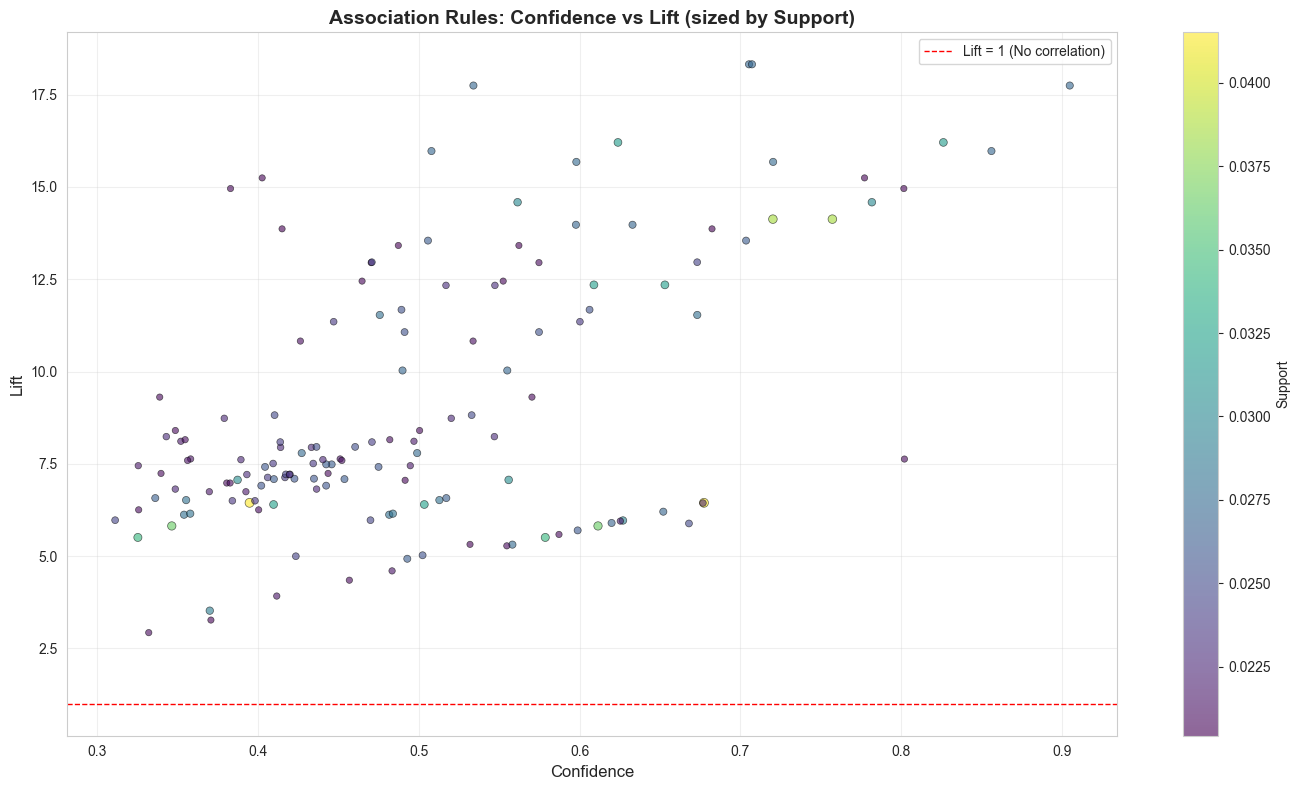

Rules with lift > 1 indicate positive correlation between antecedent and consequent


In [16]:
# Visualization: Confidence vs Lift Scatter Plot
plt.figure(figsize=(14, 8))
scatter = plt.scatter(rules_apriori['confidence'], 
                     rules_apriori['lift'], 
                     c=rules_apriori['support'], 
                     s=rules_apriori['support']*1000,
                     alpha=0.6, 
                     cmap='viridis',
                     edgecolors='black',
                     linewidth=0.5)

plt.colorbar(scatter, label='Support')
plt.xlabel('Confidence', fontsize=12)
plt.ylabel('Lift', fontsize=12)
plt.title('Association Rules: Confidence vs Lift (sized by Support)', fontsize=14, fontweight='bold')
plt.axhline(y=1, color='r', linestyle='--', linewidth=1, label='Lift = 1 (No correlation)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('screenshots/confidence_lift_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("Rules with lift > 1 indicate positive correlation between antecedent and consequent")

In [17]:
# Analyze top rules with high confidence and lift
top_rules = rules_apriori[(rules_apriori['confidence'] > 0.5) & 
                          (rules_apriori['lift'] > 2)].sort_values('lift', ascending=False)

print(f"Number of high-quality rules (confidence > 0.5 and lift > 2): {len(top_rules)}")
print("\nTop 15 high-quality association rules:")
print("="*100)

for idx, row in top_rules.head(15).iterrows():
    antecedents = ', '.join(list(row['antecedents']))
    consequents = ', '.join(list(row['consequents']))
    print(f"\nRule {idx + 1}:")
    print(f"  If customer buys: {antecedents}")
    print(f"  Then they also buy: {consequents}")
    print(f"  Support: {row['support']:.4f} | Confidence: {row['confidence']:.4f} | Lift: {row['lift']:.4f}")

Number of high-quality rules (confidence > 0.5 and lift > 2): 60

Top 15 high-quality association rules:

Rule 136:
  If customer buys: ROSES REGENCY TEACUP AND SAUCER, GREEN REGENCY TEACUP AND SAUCER
  Then they also buy: PINK REGENCY TEACUP AND SAUCER
  Support: 0.0272 | Confidence: 0.7053 | Lift: 18.3224

Rule 139:
  If customer buys: PINK REGENCY TEACUP AND SAUCER
  Then they also buy: ROSES REGENCY TEACUP AND SAUCER, GREEN REGENCY TEACUP AND SAUCER
  Support: 0.0272 | Confidence: 0.7072 | Lift: 18.3224

Rule 135:
  If customer buys: ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY TEACUP AND SAUCER
  Then they also buy: GREEN REGENCY TEACUP AND SAUCER
  Support: 0.0272 | Confidence: 0.9047 | Lift: 17.7471

Rule 140:
  If customer buys: GREEN REGENCY TEACUP AND SAUCER
  Then they also buy: ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY TEACUP AND SAUCER
  Support: 0.0272 | Confidence: 0.5341 | Lift: 17.7471

Rule 24:
  If customer buys: PINK REGENCY TEACUP AND SAUCER
  Then they also b

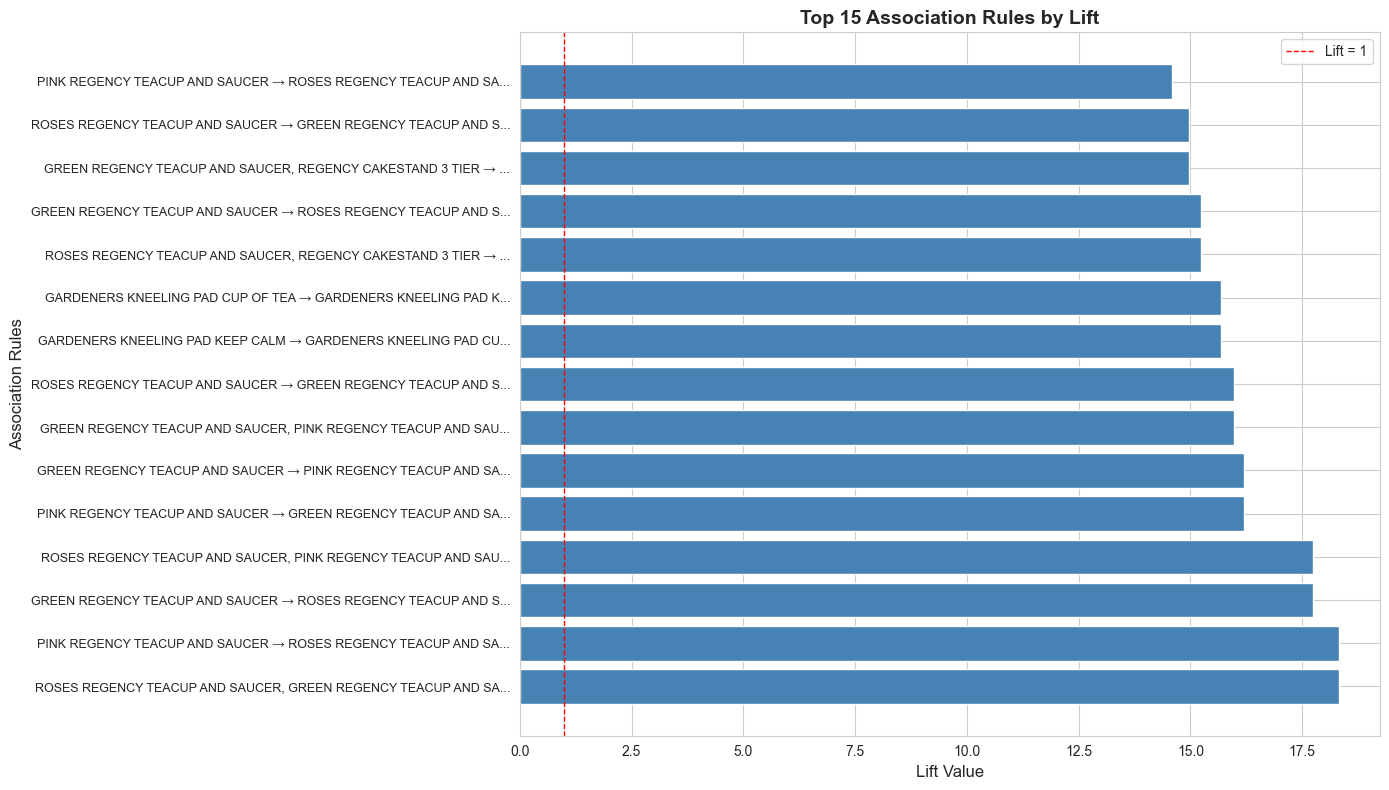

Higher lift values indicate stronger associations between items


In [18]:
# Visualization: Top 15 Rules by Lift
top_15_rules = rules_apriori.sort_values('lift', ascending=False).head(15).copy()
top_15_rules['rule'] = top_15_rules.apply(
    lambda x: f"{', '.join(list(x['antecedents'])[:2])} → {', '.join(list(x['consequents'])[:2])}", 
    axis=1
)

# Truncate long rule names
top_15_rules['rule'] = top_15_rules['rule'].str[:60] + top_15_rules['rule'].str[60:].apply(lambda x: '...' if len(x) > 0 else '')

plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(top_15_rules)), top_15_rules['lift'].values, color='steelblue')
plt.yticks(range(len(top_15_rules)), top_15_rules['rule'].values, fontsize=9)
plt.xlabel('Lift Value', fontsize=12)
plt.ylabel('Association Rules', fontsize=12)
plt.title('Top 15 Association Rules by Lift', fontsize=14, fontweight='bold')
plt.axvline(x=1, color='red', linestyle='--', linewidth=1, label='Lift = 1')
plt.legend()
plt.tight_layout()
plt.savefig('screenshots/top_rules_by_lift.png', dpi=300, bbox_inches='tight')
plt.show()

print("Higher lift values indicate stronger associations between items")

## Step 5: Comparative Analysis

Comparing the performance and results of Apriori and FP-Growth algorithms.

In [19]:
# Performance comparison
comparison_data = {
    'Metric': ['Execution Time (seconds)', 'Frequent Itemsets Found', 'Association Rules Generated'],
    'Apriori': [apriori_time, len(frequent_itemsets_apriori), len(rules_apriori)],
    'FP-Growth': [fpgrowth_time, len(frequent_itemsets_fpgrowth), len(rules_fpgrowth)]
}

comparison_df = pd.DataFrame(comparison_data)
print("Performance Comparison:")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Calculate speedup
speedup = apriori_time / fpgrowth_time
print(f"\nFP-Growth was {speedup:.2f}x faster than Apriori")
print(f"Time saved: {apriori_time - fpgrowth_time:.4f} seconds")

Performance Comparison:
                     Metric    Apriori  FP-Growth
   Execution Time (seconds)   4.093391   3.413933
    Frequent Itemsets Found 378.000000 378.000000
Association Rules Generated 150.000000 150.000000

FP-Growth was 1.20x faster than Apriori
Time saved: 0.6795 seconds


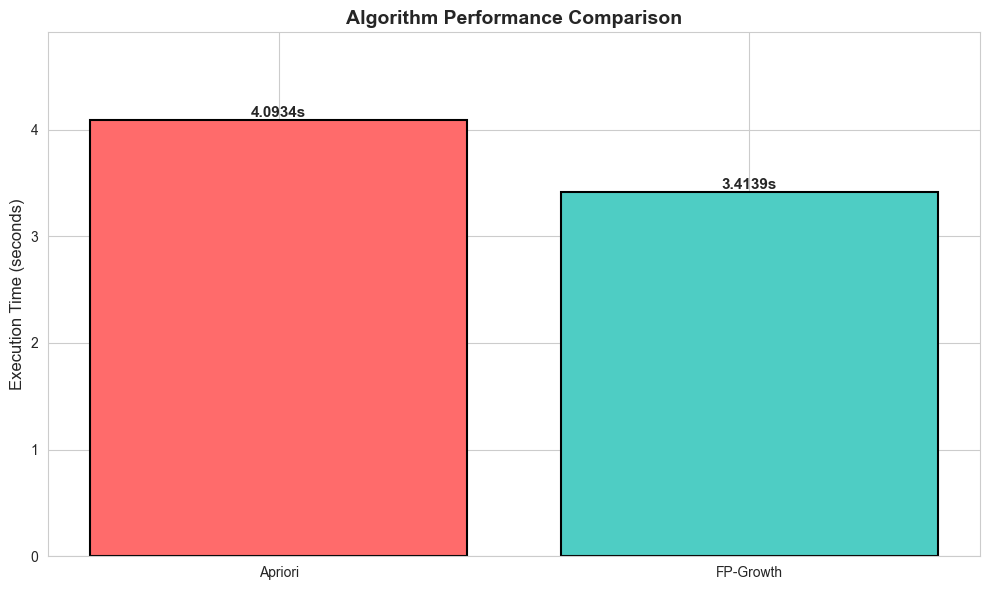

FP-Growth demonstrates superior performance due to its tree-based structure


In [20]:
# Visualization: Execution Time Comparison
plt.figure(figsize=(10, 6))
algorithms = ['Apriori', 'FP-Growth']
times = [apriori_time, fpgrowth_time]
colors = ['#FF6B6B', '#4ECDC4']

bars = plt.bar(algorithms, times, color=colors, edgecolor='black', linewidth=1.5)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.title('Algorithm Performance Comparison', fontsize=14, fontweight='bold')
plt.ylim(0, max(times) * 1.2)

# Add value labels on bars
for bar, time in zip(bars, times):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{time:.4f}s',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('screenshots/algorithm_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("FP-Growth demonstrates superior performance due to its tree-based structure")

In [21]:
# Summary of findings
print("\n" + "="*80)
print("SUMMARY OF FINDINGS")
print("="*80)

print("\n1. ALGORITHM EFFICIENCY:")
print(f"   - FP-Growth was significantly faster ({speedup:.2f}x speedup)")
print(f"   - FP-Growth avoids candidate generation, making it more efficient")
print(f"   - Both algorithms produced identical itemsets and rules")

print("\n2. DATASET CHARACTERISTICS:")
print(f"   - Total transactions analyzed: {len(transactions)}")
print(f"   - Unique items in dataset: {len(te.columns_)}")
print(f"   - Support threshold used: {min_support*100}%")
print(f"   - Confidence threshold used: {min_confidence*100}%")

print("\n3. DISCOVERED PATTERNS:")
print(f"   - Frequent itemsets discovered: {len(frequent_itemsets_apriori)}")
print(f"   - Association rules generated: {len(rules_apriori)}")
print(f"   - High-quality rules (confidence > 50%, lift > 2): {len(top_rules)}")

print("\n4. KEY INSIGHTS:")
most_common_item = df_clean['Description'].value_counts().index[0]
print(f"   - Most frequently purchased item: {most_common_item}")
print(f"   - Strong associations found between complementary products")
print(f"   - Rules with high lift values indicate profitable cross-selling opportunities")

print("\n5. CHALLENGES ENCOUNTERED:")
print("   - Data cleaning was essential to remove cancelled orders and invalid entries")
print("   - Selecting appropriate support and confidence thresholds required iteration")
print("   - Balancing between too many and too few rules required threshold tuning")
print("   - Large dataset size required careful memory management")

print("\n" + "="*80)


SUMMARY OF FINDINGS

1. ALGORITHM EFFICIENCY:
   - FP-Growth was significantly faster (1.20x speedup)
   - FP-Growth avoids candidate generation, making it more efficient
   - Both algorithms produced identical itemsets and rules

2. DATASET CHARACTERISTICS:
   - Total transactions analyzed: 19872
   - Unique items in dataset: 4002
   - Support threshold used: 2.0%
   - Confidence threshold used: 30.0%

3. DISCOVERED PATTERNS:
   - Frequent itemsets discovered: 378
   - Association rules generated: 150
   - High-quality rules (confidence > 50%, lift > 2): 60

4. KEY INSIGHTS:
   - Most frequently purchased item: WHITE HANGING HEART T-LIGHT HOLDER
   - Strong associations found between complementary products
   - Rules with high lift values indicate profitable cross-selling opportunities

5. CHALLENGES ENCOUNTERED:
   - Data cleaning was essential to remove cancelled orders and invalid entries
   - Selecting appropriate support and confidence thresholds required iteration
   - Balancin